@author: sg, SteveEckel

Single atom evolution in a MOT with no schochatic force, no gravity, no 
interaction. Using OBE.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.fields
import pylcp.tools
import time
from pylcp.common import progressBar
from scipy.optimize import fsolve
plt.style.use('paper')

### Define the problem:

Laser beams, magnetic field, and Hamiltonian.

In [3]:
laser_det = 0
det = -2.5
beta = 1.25
transform = True

laserBeams = pylcp.fields.conventional3DMOTBeams(
    beta=beta, delta=0., beam_type=pylcp.infinitePlaneWaveBeam
)
#laserBeams.beam_vector[2:7] = [] # Delete the y,z beams
#laserBeams.num_of_beams = 2

alpha = 1e-4
magField = pylcp.quadrupoleMagneticField(alpha)

# Hamiltonian for F=0->F=1
H_g, muq_g = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
H_e, muq_e = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1)
d_q = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
hamiltonian = pylcp.hamiltonian(H_g, -det*np.eye(3)+H_e, muq_g, muq_e, d_q, mass=500)

obe = pylcp.obe(laserBeams, magField, hamiltonian,
                transform_into_re_im=transform)

## Now let's do a force profile:
Let's try looking at a single force profile along the axis:

In [4]:
z = np.arange(-5.01, 5.01, 0.25)

R = {}
R['x'] = [2*z/alpha, np.zeros(z.shape), np.zeros(z.shape)]
R['y'] = [np.zeros(z.shape), 2*z/alpha, np.zeros(z.shape)]
R['z'] = [np.zeros(z.shape), np.zeros(z.shape), z/alpha]

V = {
    'x':[0.0*np.ones(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
    'y':[np.zeros(z.shape), 0.0*np.ones(z.shape), np.zeros(z.shape)],
    'z':[np.zeros(z.shape), np.zeros(z.shape), 0.0*np.ones(z.shape)]
}
for key in R:
    obe.generate_force_profile(
        R[key], V[key],
        name=key, deltat_tmax=2*np.pi*100, deltat_r=4/alpha,
        itermax=1000, progress_bar=True
    )

Completed in 9.96 s.                                                
Completed in 9.33 s.                                               
Completed in 10.46 s.                                              


Plot it up:

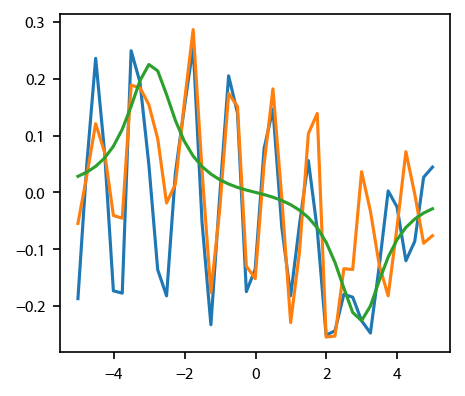

In [5]:
fig, ax = plt.subplots(1, 1)
for ii, key in enumerate(obe.profile):
    ax.plot(z, obe.profile[key].F[ii])

Obviously there is something going on with the x and y directions.  The thing that is going on is interference in the optical lattice created by the 6 beams, and it is pronounced because the atom is not moving.  Let's repeat this exercise, but average over a period of the laser lattice.

### What's the periodicity of the lasers?
Just want to make sure it is $2\pi$

In [6]:
print(obe.laserBeams['g->e'].electric_field(np.array([0., 0., 0.]), 0.)-obe.laserBeams['g->e'].electric_field(np.array([0., 6*np.pi, 0.]), 0.))

[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-5.80900982e-16+0.00000000e+00j  0.00000000e+00+8.21518047e-16j
   5.80900982e-16+0.00000000e+00j]
 [-5.80900982e-16+0.00000000e+00j  0.00000000e+00-8.21518047e-16j
   5.80900982e-16+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]]


### Now rerun, averaging over the lattice:

Again, note the the $x$ and $y$ calculation is a factor of 2 larger than $z$.

In [7]:
z = np.arange(-5.01, 5.01, 0.25)

R = {}
R['x'] = [2*z/alpha, np.zeros(z.shape), np.zeros(z.shape)]
R['y'] = [np.zeros(z.shape), 2*z/alpha, np.zeros(z.shape)]
R['z'] = [np.zeros(z.shape), np.zeros(z.shape), z/alpha]

V = {
    'x':[0.0*np.ones(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
    'y':[np.zeros(z.shape), 0.0*np.ones(z.shape), np.zeros(z.shape)],
    'z':[np.zeros(z.shape), np.zeros(z.shape), 0.0*np.ones(z.shape)]
}

Npts = 128
for key in R:
    progress = progressBar()
    for ii in range(Npts):
        obe.generate_force_profile(
            R[key] + 2*np.pi*(np.random.rand(3)-0.5).reshape(3,1), V[key],
            name=key + '_%d'%ii, deltat_tmax=2*np.pi*100, deltat_r=4/alpha,
            itermax=1000, progress_bar=False
        )
        progress.update((ii+1)/Npts)

Completed in 19:57.                                                 
Completed in 20:19.                                                 
Completed in 23:00.                                                 


Now take the average:

In [8]:
avgF = {}
for coord_key in R:
    avgF[coord_key] = np.sum([obe.profile[key].F for key in obe.profile if coord_key in key], axis=0)/Npts

Now plot it up:

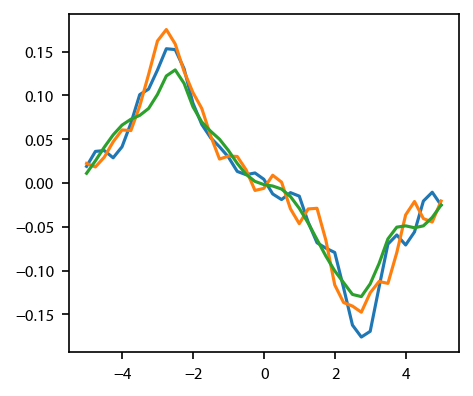

In [9]:
fig, ax = plt.subplots(1, 1)
for ii, key in enumerate(R):
    ax.plot(z, avgF[key][ii])

That looks much better.

## Now let's try evolution (without random scattering):
One can choose various initial states.  Sometimes we appear to get trapped in some lattice if we choose our initial state poorly.

In [10]:
# %% Now try to evolve some initial state!
obe.v0 = np.array([0., 0., 0.])
obe.r0 = np.random.randn(3)/alpha
#obe.r0 = np.array([0., 100., 0.])
#obe.r0 = np.array([0., 0., 10.])
obe.set_initial_rho_from_rateeq()
# obe.set_initial_rho_equally()

t_span = [0, 5e4]

obe.evolve_motion(t_span,
                  recoil_velocity=0.01,
                  progress_bar=True,
                  random_recoil=False
                 )

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `recoil_velocity`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


Completed in 4:04.                                                     


Plot 'er up:

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


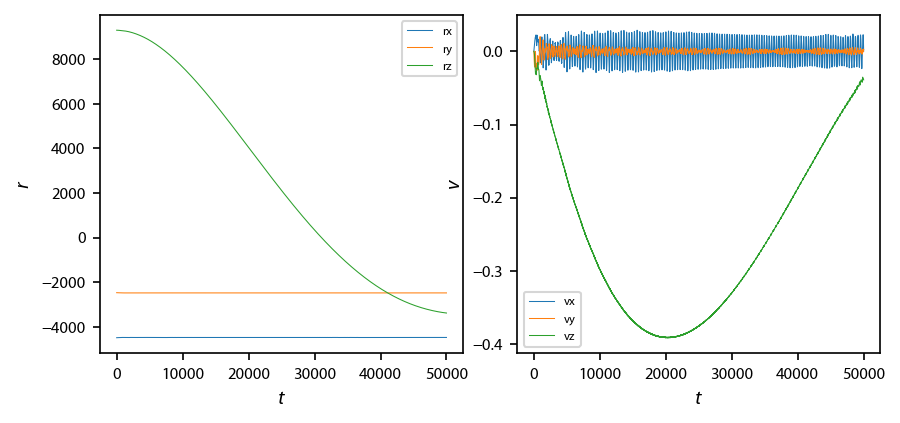

In [11]:
fig, ax = plt.subplots(1, 2, num='Optical Molasses F=0->F1', figsize=(6.5, 2.75))
ax[0].plot(obe.sol.t,obe.sol.r[0],
           label='rx', linewidth=0.5)
ax[0].plot(obe.sol.t,obe.sol.r[1],
           label='ry', linewidth=0.5)
ax[0].plot(obe.sol.t,obe.sol.r[2],
           label='rz', linewidth=0.5)
ax[0].legend(fontsize=6)
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$r$')

ax[1].plot(obe.sol.t,obe.sol.v[0],
           label='vx', linewidth=0.5)
ax[1].plot(obe.sol.t,obe.sol.v[1],
           label='vy', linewidth=0.5)
ax[1].plot(obe.sol.t,obe.sol.v[2],
           label='vz', linewidth=0.5)
ax[1].legend(fontsize=6)
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$v$')
fig.subplots_adjust(wspace=0.15)

## Now let's evolution with random scattering:
First run another test simulation:

In [12]:
# %% Now try to evolve some initial state!
obe.v0 = 0.1*np.random.randn(3)
obe.r0 = 0.1*np.random.randn(3)/alpha
obe.set_initial_rho_from_rateeq()
# obe.set_initial_rho_equally()

t_span = [0, 5e4]

obe.evolve_motion(t_span,
                  progress_bar=True,
                  random_recoil=True
                 )

Completed in 3:21.                                                   


Plot 'er up:

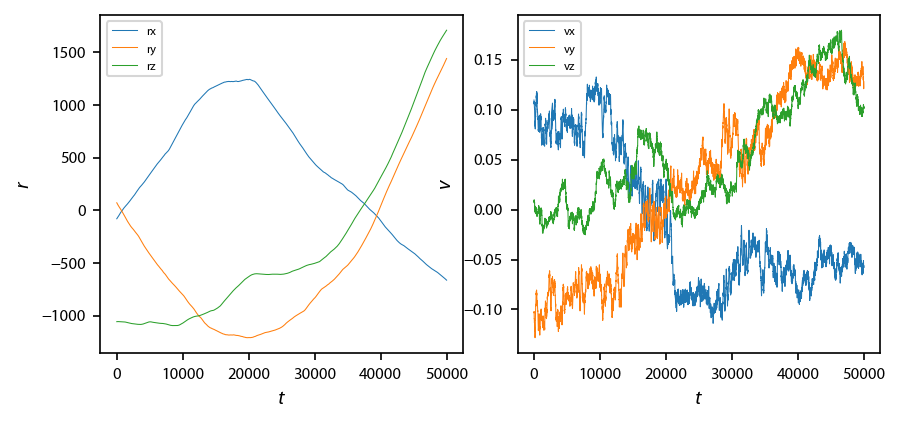

In [13]:
fig, ax = plt.subplots(1, 2, num='Optical Molasses F=0->F1', figsize=(6.5, 2.75))
ax[0].plot(obe.sol.t,obe.sol.r[0],
           label='rx', linewidth=0.5)
ax[0].plot(obe.sol.t,obe.sol.r[1],
           label='ry', linewidth=0.5)
ax[0].plot(obe.sol.t,obe.sol.r[2],
           label='rz', linewidth=0.5)
ax[0].legend(fontsize=6)
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$r$')

ax[1].plot(obe.sol.t,obe.sol.v[0],
           label='vx', linewidth=0.5)
ax[1].plot(obe.sol.t,obe.sol.v[1],
           label='vy', linewidth=0.5)
ax[1].plot(obe.sol.t,obe.sol.v[2],
           label='vz', linewidth=0.5)
ax[1].legend(fontsize=6)
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$v$')
fig.subplots_adjust(wspace=0.15)

Here's a good way to parallelize.  We export a file that contains all the relevant data, and then execute the script `run_single_sim.py`.  That grabs the data from the pickled file, and executes the sim 12 times and dumps the results into pickled files.

In [14]:
import dill, os

if hasattr(obe, 'sol'):
    del obe.sol

tmax = 1e5
args = ([0, tmax], )
kwargs = {'t_eval':np.linspace(0, tmax, 5001),
          'random_recoil':True,
          'recoil_velocity':0.01,
          'progress_bar':True,
          'max_scatter_probability':0.5,
          'record_force':False}

rscale = np.array([2, 2, 2])/alpha
roffset = np.array([0.0, 0.0, 0.0])
vscale = np.array([0.1, 0.1, 0.1])
voffset = np.array([0.0, 0.0, 0.0])

with open('parameters.pkl', 'wb') as output:
    dill.dump(obe, output)
    dill.dump(args, output)
    dill.dump(kwargs, output)
    dill.dump((rscale, roffset, vscale, voffset), output)

This code reads the pickled files:

In [87]:
files = os.listdir(path='./sims/')

sols = []
for file in files:
    if file.endswith('.pkl'):
        with open('sims/'+ file, 'rb') as input:
            sols.append(dill.load(input))
            
print(len(sols))

96


And now, plot them up:

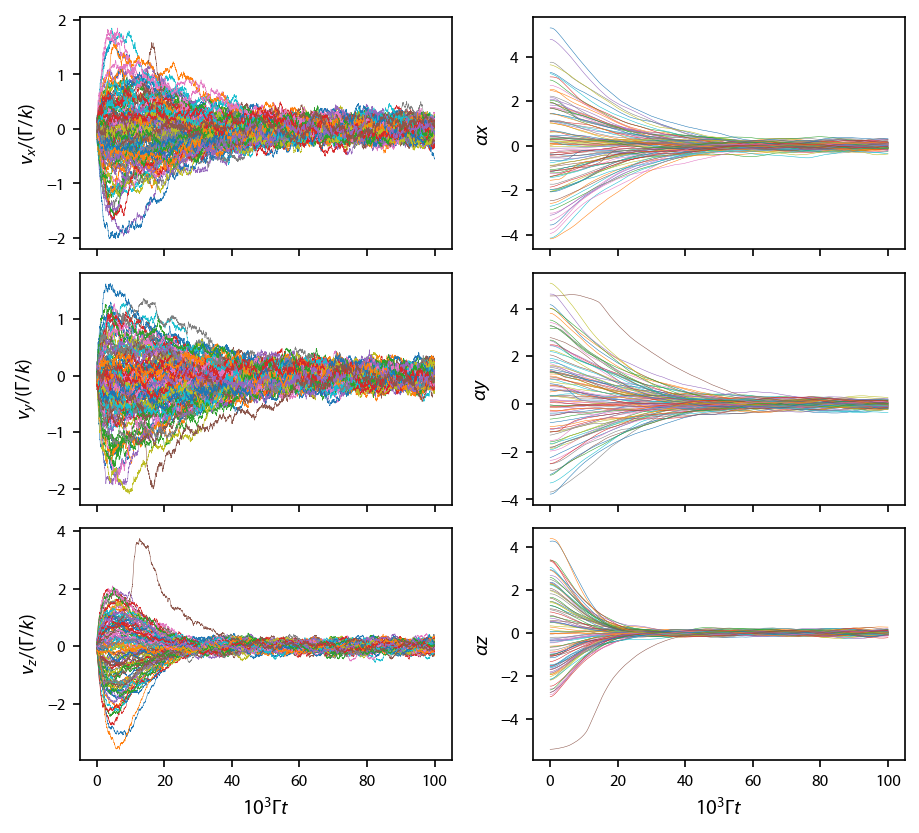

In [92]:
fig, ax = plt.subplots(3, 2, figsize=(6.25, 2*2.75))
for sol in sols:
    for ii in range(3):
        ax[ii, 0].plot(sol.t/1e3, sol.v[ii], linewidth=0.25)
        ax[ii, 1].plot(sol.t/1e3, sol.r[ii]*alpha, linewidth=0.25)

"""for ax_i in ax[:, 0]:
    ax_i.set_ylim((-0.75, 0.75))
for ax_i in ax[:, 1]:
    ax_i.set_ylim((-4., 4.))"""
for ax_i in ax[-1, :]:
    ax_i.set_xlabel('$10^3 \Gamma t$')
for jj in range(2):
    for ax_i in ax[jj, :]:
        ax_i.set_xticklabels('')
for ax_i, lbl in zip(ax[:, 0], ['x','y','z']):
    ax_i.set_ylabel('$v_' + lbl + '/(\Gamma/k)$')
for ax_i, lbl in zip(ax[:, 1], ['x','y','z']):
    ax_i.set_ylabel('$\\alpha ' + lbl + '$')
    
fig.subplots_adjust(left=0.1, bottom=0.08, wspace=0.22)

Reconstruct the force:

In [90]:
for sol in sols:
    sol.F, sol.f_laser, sol.f_laser_q, sol.f_mag = obe.force(sol.r, sol.t, sol.rho, return_details=True)

Let's now look at the average force as a function of position and velocity for the random particles.  That takes some minor rearrangement the solutions accordingly.

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


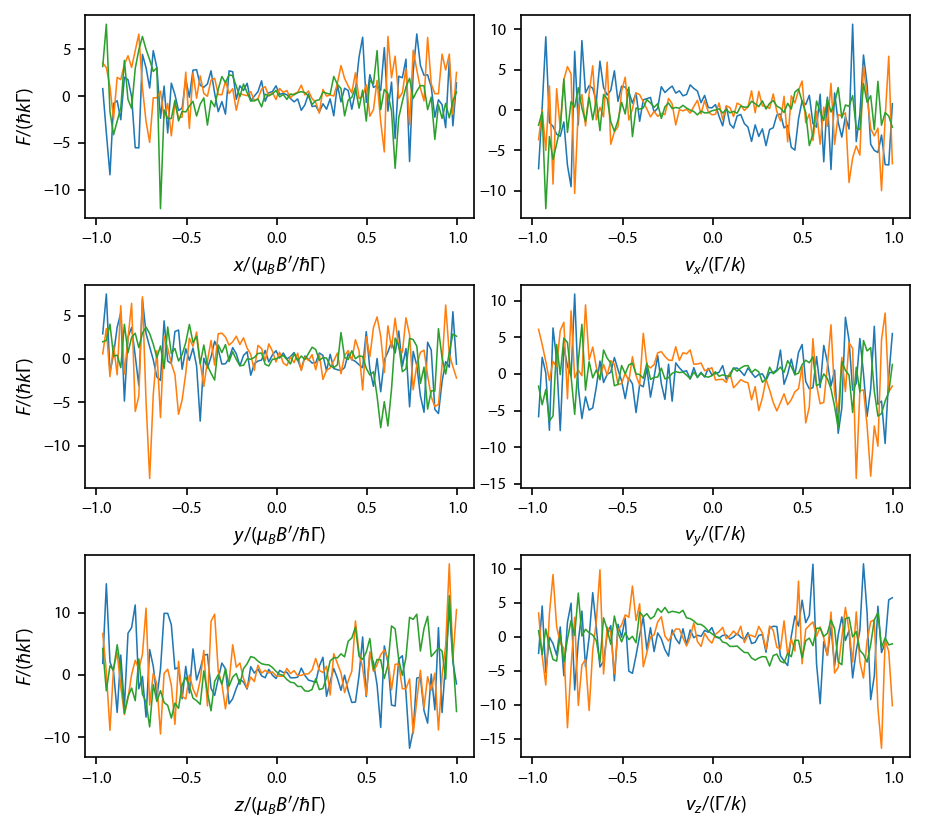

In [93]:
allr = np.concatenate([sol.r.T for sol in sols]).T
allv = np.concatenate([sol.v.T for sol in sols]).T
allF = np.concatenate([sol.F.T for sol in sols]).T

x = np.arange(-1, 1, 0.02)
v = np.arange(-1, 1, 0.02)

xc = x[:-1]+np.mean(np.diff(x))/2
vc = v[:-1]+np.mean(np.diff(v))/2

avgFx = np.zeros((3, 3, x.size-1))
stdFx = np.zeros((3, 3, x.size-1))

for jj in range(3):
    for ii, (x_l, x_r) in enumerate(zip(x[:-1],x[1:])):
        inds = np.bitwise_and(allr[jj]*alpha <= x_r, allr[jj]*alpha > x_l)
        if np.sum(inds)>0:
            for kk in range(3):
                avgFx[kk, jj, ii] = np.mean(allF[kk, inds])
                stdFx[kk, jj, ii] = np.std(allF[kk, inds])
        else:
            avgFx[:, jj, ii] = np.nan
            avgFx[:, jj, ii] = np.nan
            
avgFv = np.zeros((3, 3, v.size-1))
stdFv = np.zeros((3, 3, v.size-1))

for jj in range(3):
    for ii, (v_l, v_r) in enumerate(zip(v[:-1],v[1:])):
        inds = np.bitwise_and(allv[jj] <= v_r, allv[jj] > v_l)
        if np.sum(inds)>0:
            for kk in range(3):
                avgFv[kk, jj, ii] = np.mean(allF[kk, inds])
                stdFv[kk, jj, ii] = np.std(allF[kk, inds])
        else:
            avgFv[:, jj, ii] = np.nan
            avgFv[:, jj, ii] = np.nan
                          
fig, ax = plt.subplots(3, 2, figsize=(6.25, 2*2.75))

ax[0, 0].plot(xc+0.05/2, 1e3*avgFx[:, 0].T, linewidth=0.75)
ax[1, 0].plot(xc+0.05/2, 1e3*avgFx[:, 1].T, linewidth=0.75)
ax[2, 0].plot(xc+0.05/2, 1e3*avgFx[:, 2].T, linewidth=0.75)

ax[0, 1].plot(vc+0.05/2, 1e3*avgFv[:, 0].T, linewidth=0.75)
ax[1, 1].plot(vc+0.05/2, 1e3*avgFv[:, 1].T, linewidth=0.75)
ax[2, 1].plot(vc+0.05/2, 1e3*avgFv[:, 2].T, linewidth=0.75)

[ax[jj, 0].set_xlabel('$%s/(\mu_B B\'/\hbar\Gamma)$' % lbl) for (jj, lbl) in enumerate(['x', 'y', 'z'])]
[ax[jj, 1].set_xlabel('$v_%s/(\Gamma/k)$' % lbl) for (jj, lbl) in enumerate(['x', 'y', 'z'])]

[ax[jj, 0].set_ylabel('$F/(\hbar k \Gamma)$') for jj in range(3)]

fig.subplots_adjust(left=0.1, bottom=0.08, wspace=0.12, hspace=0.33)

Show confining force and damping forces in $x$, $y$, and $z$